<a href="https://colab.research.google.com/github/AdamClarkStandke/GenerativeDeepLearning/blob/main/AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
from tensorflow.keras import datasets
(x_train,y_train), (x_test,y_test) = datasets.fashion_mnist.load_data()

In [4]:
def preprocess(imgs):
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs

x_train = preprocess(x_train)
x_test = preprocess(x_test)

# Encoder


In [22]:
from tensorflow.keras import layers, models, metrics

encoder_input = layers.Input(shape=(32, 32, 1), name = "encoder_input")
x = layers.Conv2D(32, (3, 3), strides = 2, activation = 'relu', padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides = 2, activation = 'relu', padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides = 2, activation = 'relu', padding="same")(x)
shape_before_flattening = x.shape[1:]

x = layers.Flatten()(x)
# latent space will be 2-dimensions to make it easier to plot
encoder_output = layers.Dense(2, name="encoder_output")(x)

encoder = models.Model(encoder_input, encoder_output)

In [11]:
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 32)        320       
                                                                 
 conv2d_10 (Conv2D)          (None, 8, 8, 64)          18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
Total params: 96770 (378.01 KB)
Trainable params: 96770 (378.

# Decoder

In [15]:
decoder_input = layers.Input(shape=(2,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation = 'relu', padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation = 'relu', padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation = 'relu', padding="same"
)(x)
decoder_output = layers.Conv2D(
    1,
    (3, 3),
    strides = 1,
    activation="sigmoid",
    padding="same",
    name="decoder_output"
)(x)

decoder = models.Model(decoder_input, decoder_output)

# Training AutoEncoder

In [25]:
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

autoencoder = models.Model(encoder_input, decoder(encoder_output))
autoencoder.compile(optimizer="adam", loss=root_mean_squared_error)
autoencoder.fit(
    x_train,
    x_train,
    epochs=5,
    batch_size=100,
    shuffle=True,
    validation_data=(x_test, x_test),
)

Epoch 1/5
600/600 [==============================] - 342s 567ms/step - loss: 0.1827 - val_loss: 0.1578
Epoch 2/5
600/600 [==============================] - 343s 572ms/step - loss: 0.1560 - val_loss: 0.1542
Epoch 3/5
600/600 [==============================] - 339s 565ms/step - loss: 0.1529 - val_loss: 0.1523
Epoch 4/5
600/600 [==============================] - 346s 577ms/step - loss: 0.1508 - val_loss: 0.1502
Epoch 5/5
600/600 [==============================] - 326s 544ms/step - loss: 0.1495 - val_loss: 0.1485


# Generating non-novel images

In [26]:
example_images = x_test[:5000]
predictions = autoencoder.predict(example_images)

157/157 [==============================] - 12s 76ms/step


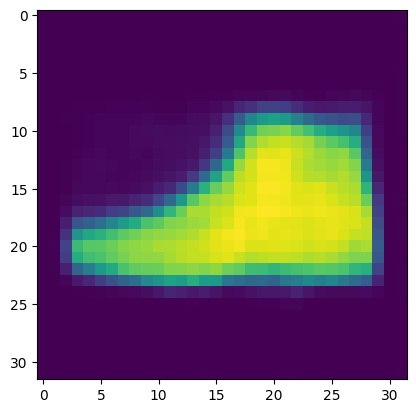

In [35]:
import matplotlib.pyplot as plt
plt.imshow(predictions[43, :, :, :])

# Visualizing the Latent Space

157/157 [==============================] - 3s 18ms/step


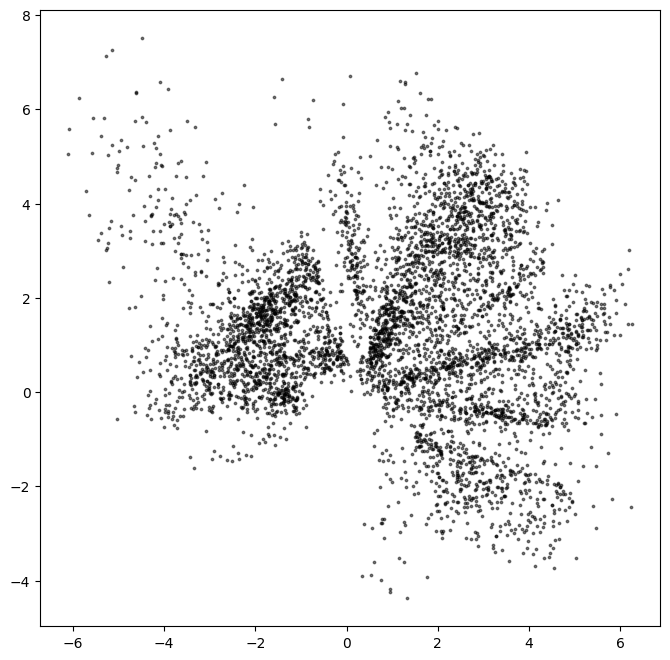

In [36]:
embeddings = encoder.predict(example_images)
plt.figure(figsize=(8, 8))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=3)

# Generating novel images using the decoder

In [37]:
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)
# taking random uniform sample from latent space
sample = np.random.uniform(mins, maxs, size=(18, 2))
reconstructions = decoder.predict(sample)

1/1 [==============================] - 1s 647ms/step


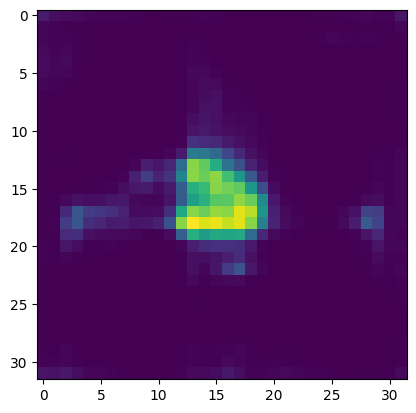

In [45]:
plt.imshow(reconstructions[8, :, :, 0])

1/1 [==============================] - 0s 23ms/step


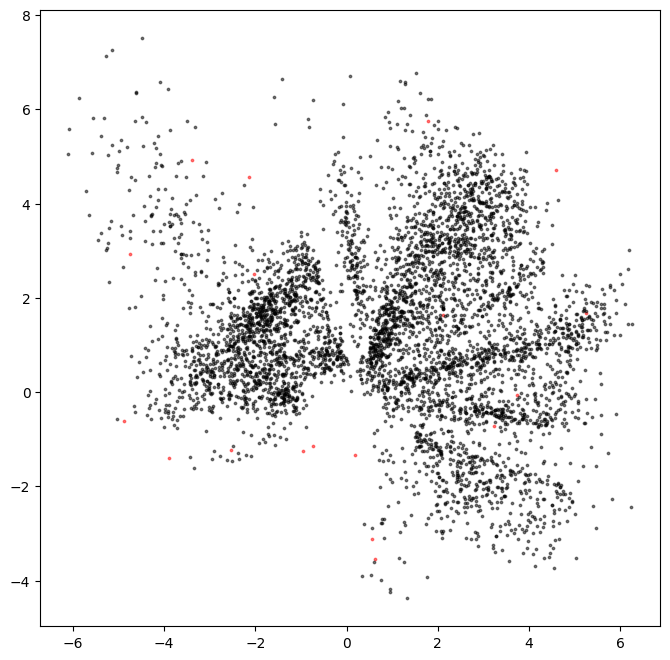

In [51]:
embeddingsTwo = encoder.predict(reconstructions)
plt.figure(figsize=(8, 8))
plt.scatter(embeddingsTwo[:, 0], embeddingsTwo[:, 1], c="red", alpha=0.5, s=3)
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=3)
plt.show()